In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import drive
#drive.mount('/content/drive') # This needs to be changed but Im not sure what too
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
import sklearn.svm as svm
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix
import seaborn as sb
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
file_path_batting = 'https://raw.githubusercontent.com/jhelto12/4105_Intro_to_ML/refs/heads/main/final_project/.csv%20files/Batting.csv' # When we figure out drive mounting we need to figure out this stuff too
file_path_pitching = 'https://raw.githubusercontent.com/jhelto12/4105_Intro_to_ML/refs/heads/main/final_project/.csv%20files/Pitching.csv'
file_path_HOF = 'https://raw.githubusercontent.com/jhelto12/4105_Intro_to_ML/refs/heads/main/final_project/.csv%20files/HallOfFame.csv'
file_path_fielding = 'https://raw.githubusercontent.com/jhelto12/4105_Intro_to_ML/refs/heads/main/final_project/.csv%20files/Fielding.csv'
file_path_salaries = 'https://raw.githubusercontent.com/jhelto12/4105_Intro_to_ML/refs/heads/main/final_project/.csv%20files/Salaries.csv'
raw_batting = pd.DataFrame(pd.read_csv(file_path_batting))
raw_pitching = pd.DataFrame(pd.read_csv(file_path_pitching))
raw_HOF = pd.DataFrame(pd.read_csv(file_path_HOF))
raw_fielding = pd.DataFrame(pd.read_csv(file_path_fielding))
raw_salaries = pd.DataFrame(pd.read_csv(file_path_salaries))

In [89]:
def cutoff_year(x):
  return x.drop(x[x['yearID'] < 1936].index)

In [90]:
def cutoff_year_salaries(x):
    return x.drop(x[x['yearID'] < 1985].index)

In [91]:
def fielding_map(x):
  return ({'P': 1, 'C': 2, '1B': 3, '2B': 4, '3B': 5, 'SS': 6, 'OF': 7, 'LF' : 8, 'RF' : 9, 'CF' : 10, 'DH' : 11}).get(x, x)

In [92]:
def league_map(x):
  return ({'NL' : 1, 'AL' : 0}).get(x, x)

In [93]:
def HOF_map_yn(x):
  return ({'Y': 1, 'N': 0}).get(x, x)

In [94]:
def HOF_map_voting(x):
  return ({'Veterans': 0, 'BBWAA': 1, 'Old Timers': 2, 'Special Election': 3, 'Nominating Vote': 4, 'Final Ballot': 5}).get(x, x)

In [95]:
def teams(x):
  return ({'PHI': 0, 'CHN' : 1, 'CLE' : 2, 'BOS' : 3, 'SLN' : 4, 'SLA' : 5, 'WS1' : 6, 'CHA' : 7, 'PHA' : 8, 'DET' : 9, 'BSN' : 10, 'BRO': 11 , 'NY1': 12, 'PIT': 13, 'CIN' : 14, 'NYA': 15, 'ML1' : 16,
                'BAL' : 17, 'KC1': 18, 'SFN' : 19, 'LAN' : 20, 'MIN' : 21, 'LAA' :22, 'WS2' : 23, 'HOU' : 24, 'NYN' : 25, 'CAL' : 26, 'ATL' : 27, 'OAK' : 28, 'KCA' : 29, 'MON' : 30, 'SDN' : 31, 'ML4' : 32,
                'SE1' : 33, 'TEX' : 34, 'SEA' : 35, 'TOR' : 36, 'FLO' : 37, 'COL' : 38, 'ANA' : 39, 'ARI' : 40, 'MIL' : 41, 'TBA' : 42, 'WAS' : 43, 'MIA' : 44}).get(x, x)


In [96]:
def replace_nan_with_zero(df):
    for index, row in df.iterrows():
        for column, value in row.items():
            if pd.isna(value):  # Check if the value is NaN
                df.at[index, column] = 0  # Replace NaN with 0
    return df

In [97]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):

    # Generate confusion matrix
    cmatrix = confusion_matrix(y_true, y_pred)

    # Create figure and axis objects
    fig, ax = plt.subplots()

    # Set tick marks based on the number of class names
    tick_marks = np.arange(len(class_names))

    # Set the labels for the x and y ticks
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Create the heatmap
    sns.heatmap(pd.DataFrame(cmatrix), annot=True, cmap="YlGnBu", fmt='g', ax=ax)

    # Adjust label positions and plot layout
    ax.xaxis.set_label_position("top")
    plt.tight_layout()

    # Add title and labels
    plt.title(title, y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # Show the plot
    plt.show()

In [98]:
def adjust_for_inflation(df, value_column, year_column, base_year=2022, cpi_data=None):

    # Check if CPI data is provided, otherwise use default data
    if cpi_data is None:
        raise ValueError("CPI data is required to adjust for inflation.")

    # Get the CPI value for the base year
    base_cpi = cpi_data.get(base_year)
    if base_cpi is None:
        raise ValueError(f"CPI data for the base year {base_year} is missing.")

    # Create a new column for the adjusted value
    adjusted_values = []

    for _, row in df.iterrows():
        year = row[year_column]
        original_value = row[value_column]

        # Get the CPI for the current year
        current_cpi = cpi_data.get(year)
        if current_cpi is None:
            raise ValueError(f"CPI data for year {year} is missing.")

        # Adjust the value for inflation
        adjusted_value = original_value * (current_cpi / base_cpi)
        adjusted_values.append(adjusted_value)

    # Add the adjusted values to the DataFrame
    df['adjusted_value'] = adjusted_values
    return df

In [99]:
#Inflation calculation numbers
cpi_data = {
    1980: 82.4,
    1981: 90.9,
    1982: 96.5,
    1983: 99.6,
    1984: 103.9,
    1985: 107.6,
    1986: 109.6,
    1987: 113.6,
    1988: 118.3,
    1989: 124.0,
    1990: 130.7,
    1991: 136.2,
    1992: 140.3,
    1993: 144.5,
    1994: 148.2,
    1995: 152.4,
    1996: 156.9,
    1997: 160.5,
    1998: 163.0,
    1999: 166.6,
    2000: 172.2,
    2001: 177.1,
    2002: 179.9,
    2003: 184.0,
    2004: 188.9,
    2005: 195.3,
    2006: 201.6,
    2007: 207.3,
    2008: 215.3,
    2009: 214.9,
    2010: 218.1,
    2011: 224.9,
    2012: 229.6,
    2013: 233.0,
    2014: 236.7,
    2015: 237.0,
    2016: 240.0,
    2017: 245.1,
    2018: 251.1,
    2019: 255.7,
    2020: 258.8,
    2021: 271.0,
    2022: 292.7,
    2023: 304.7,
    2024: 314.0,
}

In [100]:
def calculate_precision_recall(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    return precision, recall

In [101]:
def plot_weight_histogram(model, layer_name=None):
    # If a specific layer name is provided, extract its weights
    if layer_name:
        layer = model.get_layer(layer_name)
        weights = layer.get_weights()[0]  # Weights are usually in the first index
    else:
        # Extract weights from all layers
        weights = []
        for layer in model.layers:
            if len(layer.get_weights()) > 0:
                layer_weights = layer.get_weights()[0]
                weights.append(layer_weights.flatten())  # Flatten weights for histogram

        # Flatten all weights from all layers into a single array
        weights = np.concatenate(weights)

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(weights, kde=True, color='blue', bins=50)
    plt.title('Weight Distribution of Model' if not layer_name else f'Weight Distribution of Layer: {layer_name}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [102]:
def plot_linear_model_weights(model):
    # Extract the weights (coefficients) of the model
    weights = model.weight.detach().numpy().flatten()

    # If the model has intercepts (e.g., for logistic regression or linear regression), you can optionally include them
    intercept = model.bias.detach().numpy() if hasattr(model, 'bias') else None

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(weights, kde=True, color='blue', bins=20)

    # Adding title and labels
    plt.title('Weight Distribution of Batting Salary Model')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')

    if intercept is not None:
        plt.axvline(intercept, color='red', linestyle='--', label='Intercept')
        plt.legend()

    plt.grid(True)
    plt.show()

Data manipulation starts below

In [103]:
only_HOF = raw_HOF[['playerID', 'inducted']]
only_HOF['inducted'] = only_HOF['inducted'].map(HOF_map_yn)
only_HOF.head()

<ipython-input-103-be8fc52a5ebd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_HOF['inducted'] = only_HOF['inducted'].map(HOF_map_yn)


,playerID,inducted
0,cobbty01,1
1,ruthba01,1
2,wagneho01,1
3,mathech01,1
4,johnswa01,1


In [104]:
only_salaries = raw_salaries[['playerID','yearID', 'salary']]
only_salaries = adjust_for_inflation(only_salaries, 'salary', 'yearID', cpi_data=cpi_data)
only_salaries = only_salaries[['playerID', 'adjusted_value']]
only_salaries.rename(columns={'adjusted_value': 'salary'}, inplace = True)
only_salaries.head()

<ipython-input-98-eedecaceeeb0>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['adjusted_value'] = adjusted_values
<ipython-input-104-f8607083d153>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_salaries.rename(columns={'adjusted_value': 'salary'}, inplace = True)


,playerID,salary
0,barkele01,319822.343697
1,bedrost01,202186.539119
2,benedbr01,200348.479672
3,campri01,232820.740690
4,ceronri01,229757.430817


In [105]:
# batting data
batting_list = ['playerID', 'yearID', 'G', 'AB','R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']
adj_batting_list = ['playerID', 'yearID', 'G', 'AB','R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO']
raw_batting = raw_batting[adj_batting_list]
raw_batting = cutoff_year(raw_batting)
#raw_batting['lgID'] = raw_batting['lgID'].map(league_map)
#raw_batting['teamID'] = raw_batting['teamID'].map(teams)
no_nan_batting = replace_nan_with_zero(raw_batting)
no_nan_batting.head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO
26537,allenet01,1936,30,125.0,21.0,37.0,3.0,1.0,1.0,9.0,4.0,0.0,4.0,8.0
26538,allenet01,1936,91,373.0,47.0,110.0,18.0,6.0,3.0,39.0,12.0,0.0,13.0,30.0
26539,allenjo02,1936,37,87.0,12.0,14.0,0.0,0.0,0.0,10.0,0.0,0.0,6.0,18.0
26540,almadme01,1936,96,320.0,40.0,81.0,16.0,4.0,1.0,21.0,2.0,4.0,24.0,15.0
26541,alstowa01,1936,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Players sometimes play for 2 teams in a single year, giving them two entries with their playerID and yearID. Below is trying to merge them into a single row per playerID/yearID

In [106]:
#Pitching Data
pitching_list = ['playerID','yearID', 'stint', 'teamID', 'lgID','W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'WP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP']
adj_pitching_list = ['playerID','yearID', 'stint', 'teamID', 'lgID','W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'WP', 'BK', 'BFP', 'GF', 'R']
raw_pitching = raw_pitching[adj_pitching_list]
raw_pitching = cutoff_year(raw_pitching)
raw_pitching['lgID'] = raw_pitching['lgID'].map(league_map)
raw_pitching['teamID'] = raw_pitching['teamID'].map(teams)
no_nan_pitching = replace_nan_with_zero(raw_pitching)
raw_pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,H,ER,HR,BB,SO,WP,BK,BFP,GF,R
9961,allenjo02,1936,1,2,0,20,10,36,31,19,...,234,93,5,97,165,13.0,0,1030.0,4.0,108
9962,andreiv01,1936,1,5,0,7,12,36,25,11,...,221,103,19,50,33,2.0,1,835.0,5.0,109
9963,applepe01,1936,1,6,0,14,9,38,20,12,...,199,79,7,77,77,5.0,0,868.0,17.0,94
9964,archefr01,1936,1,8,0,2,3,6,5,2,...,41,26,3,15,9,0.0,0,164.0,1.0,28
9965,aukerel01,1936,1,9,0,13,16,35,31,14,...,263,117,11,83,66,1.0,0,970.0,1.0,140


In [107]:
#Fielding Data
fielding_list = ['playerID', 'yearID', 'stint', 'teamID', 'lgID','POS', 'G', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'WP', 'SB', 'CS', 'ZR']
adj_fielding_list = ['playerID', 'yearID','POS', 'G', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP']
raw_fielding = raw_fielding[adj_fielding_list]
raw_fielding = cutoff_year(raw_fielding)
raw_fielding['POS'] = raw_fielding['POS'].map(fielding_map)
#raw_fielding['lgID'] = raw_fielding['lgID'].map(league_map)
#raw_fielding['teamID'] = raw_fielding['teamID'].map(teams)
no_nan_fielding = replace_nan_with_zero(raw_fielding)
no_nan_fielding.head()

,playerID,yearID,POS,G,GS,InnOuts,PO,A,E,DP
39053,allenet01,1936,7,30,0.0,0.0,82.0,1.0,4.0,0.0
39054,allenet01,1936,7,89,0.0,0.0,191.0,2.0,4.0,2.0
39055,allenjo02,1936,1,36,0.0,0.0,9.0,50.0,2.0,1.0
39056,almadme01,1936,7,81,0.0,0.0,144.0,9.0,2.0,2.0
39057,alstowa01,1936,3,1,0.0,0.0,1.0,0.0,1.0,0.0


In [108]:
aggregated_batting = no_nan_batting.groupby(['yearID', 'playerID']).sum().reset_index()
aggregated_fielding = no_nan_fielding.groupby(['yearID', 'playerID']).sum().reset_index()
aggregated_pitching = no_nan_pitching.groupby(['yearID', 'playerID']).sum().reset_index()
merged_batting_fielding = pd.merge(aggregated_batting, aggregated_fielding, on=['yearID', 'playerID'], how='inner')
merged_pitching_fielding = pd.merge(aggregated_pitching, aggregated_fielding, on=['yearID', 'playerID'], how='inner')
merged_batting_fielding_w_salary = pd.merge(merged_batting_fielding, only_salaries, how='inner', on='playerID')
merged_pitching_fielding_w_salary = pd.merge(merged_pitching_fielding, only_salaries, how='inner', on='playerID')
merged_batting_fielding_w_hof = pd.merge(merged_batting_fielding, only_HOF, how='inner', on='playerID')
merged_pitching_fielding_w_hof = pd.merge(merged_pitching_fielding, only_HOF, how='inner', on='playerID')

In [109]:
batter_IDs_salary = merged_batting_fielding_w_salary.pop('playerID')
pitcher_IDs_salary = merged_pitching_fielding_w_salary.pop('playerID')
batter_IDs_hof = merged_batting_fielding_w_hof.pop('playerID')
pitcher_IDs_hof = merged_pitching_fielding_w_hof.pop('playerID')

salary_batters_cleaned = merged_batting_fielding_w_salary.pop('salary')
salary_pitchers_cleaned = merged_pitching_fielding_w_salary.pop('salary')
hof_batters_cleaned = merged_batting_fielding_w_hof.pop('inducted')
hof_pitching_cleaned = merged_pitching_fielding_w_hof.pop('inducted')

Pop various datapoints off before running the code below if you want to see how it impacts the models

In [110]:
# SVM Loss function
def hinge_loss(y_pred, grand_truth):
    return torch.mean(torch.clamp(1 - grand_truth * y_pred, min = 0))

In [111]:
batting_standardized_salary = StandardScaler().fit_transform(merged_batting_fielding_w_salary)
pitching_standardized_salary = StandardScaler().fit_transform(merged_pitching_fielding_w_salary)
batting_standardized_hof = StandardScaler().fit_transform(merged_batting_fielding_w_hof)
pitching_standardized_hof = StandardScaler().fit_transform(merged_pitching_fielding_w_hof)
# Dont need to standardize the Y values, HOF and Salaries

In [112]:
batting_train_salary, batting_test_salary, salary_train_batting, salary_test_batting = train_test_split(batting_standardized_salary, salary_batters_cleaned, test_size=.2, random_state=21)
pitching_train_salary, pitching_test_salary, salary_train_pitching, salary_test_pitching = train_test_split(pitching_standardized_salary, salary_pitchers_cleaned, test_size=.2, random_state=10)
batting_train_hof, batting_test_hof, hof_train_batting, hof_test_batting = train_test_split(batting_standardized_hof, hof_batters_cleaned, test_size=.2, random_state=11)
pitching_train_hof, pitching_test_hof, hof_train_pitching, hof_test_pitching = train_test_split(pitching_standardized_hof, hof_pitching_cleaned, test_size=.2, random_state=46)

All data manipulation is done by this point. Below is the model and associated parameters

In [113]:
num_batting_values_salary = batting_train_salary.shape[1]
num_pitching_values_salary = pitching_train_salary.shape[1]
num_batting_values_hof = batting_train_hof.shape[1]
num_pitching_values_hof = pitching_train_hof.shape[1]

In [114]:
salary_batting_input = num_batting_values_salary                     # Depends on which values you want to look into
hof_batting_input = num_batting_values_hof
salary_pitching_input = num_pitching_values_salary
hof_pitching_input = num_pitching_values_hof                         # Depends on which values for HOF you want in your model

salary_batting_linear_model = torch.nn.Linear(salary_batting_input, 1)  # Using Torch instead of building own linear regression so that we can use tensors
salary_pitching_linear_model = torch.nn.Linear(salary_pitching_input, 1)

salary_batting_loss = torch.nn.MSELoss()
salary_pitching_loss = torch.nn.MSELoss()
#hof_batting_loss = hinge_loss()
#hof_pitching_loss = hinge_loss()

salary_batting_optimizer = torch.optim.SGD(salary_batting_linear_model.parameters(), lr=1e-2)
salary_pitching_optimizer = torch.optim.SGD(salary_pitching_linear_model.parameters(), lr=1e-2)

In [115]:
salary_batting_hidden_1 = 10
salary_batting_hidden_2 = 10
salary_batting_hidden_3 = 10

salary_pitching_hidden_1 = 10
salary_pitching_hidden_2 = 10
salary_pitching_hidden_3 = 10

hof_batting_hidden_1 = 10
hof_batting_hidden_2 = 10
hof_batting_hidden_3 = 10

hof_pitching_hidden_1 = 10
hof_pitching_hidden_2 = 10
hof_pitching_hidden_3 = 10

In [116]:
salary_batting_fully_connected = torch.nn.Sequential(torch.nn.Linear(salary_batting_input, salary_batting_hidden_1), torch.nn.ReLU(),
                                             torch.nn.Linear(salary_batting_hidden_1, salary_batting_hidden_2), torch.nn.ReLU(),
                                             torch.nn.Linear(salary_batting_hidden_2, salary_batting_hidden_3), torch.nn.ReLU(),
                                             torch.nn.Linear(salary_batting_hidden_3, 1))

salary_pitching_fully_connected = torch.nn.Sequential(torch.nn.Linear(salary_pitching_input, salary_pitching_hidden_1), torch.nn.ReLU(),
                                             torch.nn.Linear(salary_pitching_hidden_1, salary_pitching_hidden_2), torch.nn.ReLU(),
                                             torch.nn.Linear(salary_pitching_hidden_2, salary_pitching_hidden_3), torch.nn.ReLU(),
                                             torch.nn.Linear(salary_pitching_hidden_3, 1))

hof_batting_fully_connected = torch.nn.Sequential(torch.nn.Linear(hof_batting_input, hof_batting_hidden_1), torch.nn.ReLU(),
                                          torch.nn.Linear(hof_batting_hidden_1, hof_batting_hidden_2), torch.nn.ReLU(),
                                          torch.nn.Linear(hof_batting_hidden_2, hof_batting_hidden_3), torch.nn.ReLU(),
                                          torch.nn.Linear(hof_batting_hidden_3, 2), torch.nn.LogSoftmax())

hof_pitching_fully_connected = torch.nn.Sequential(torch.nn.Linear(hof_pitching_input, hof_pitching_hidden_1), torch.nn.ReLU(),
                                          torch.nn.Linear(hof_pitching_hidden_1, hof_pitching_hidden_2), torch.nn.ReLU(),
                                          torch.nn.Linear(hof_pitching_hidden_2, hof_pitching_hidden_3), torch.nn.ReLU(),
                                          torch.nn.Linear(hof_pitching_hidden_3, 2), torch.nn.LogSoftmax())

In [117]:
salary_batting_fc_optimizer = torch.optim.SGD(salary_batting_fully_connected.parameters(), lr=1e-2)
salary_pitching_fc_optimizer = torch.optim.SGD(salary_pitching_fully_connected.parameters(), lr=1e-2)

hof_batting_fc_optimizer = torch.optim.SGD(hof_batting_fully_connected.parameters(), lr=1e-2)
hof_pitching_fc_optimizer = torch.optim.SGD(hof_pitching_fully_connected.parameters(), lr=1e-2)

In [118]:
def linear_training_loop(n_epochs, optimizer, model, loss_fn, train_x, val_x, train_y, val_y):
    for epoch in range(1, n_epochs + 1):
        pred_y = model(train_x)
        train_loss = loss_fn(pred_y, train_y)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},")

In [119]:
def svm_training_loop(n_epochs, optimizer, model, train_x, val_x, train_y, val_y):
    for epoch in range(1, n_epochs + 1):
        pred_y = model(train_x)
        train_loss = hinge_loss(pred_y, train_y)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},")


In [120]:
batting_train_salary = torch.from_numpy(batting_train_salary).float()
salary_train_batting = torch.from_numpy(salary_train_batting.to_numpy()).float()

In [121]:
batting_test_salary = torch.from_numpy(batting_test_salary).float()
salary_test_batting = torch.from_numpy(salary_test_batting.to_numpy()).float()

In [122]:
batting_salary_data = TensorDataset(batting_train_salary, salary_train_batting)
batting_salary_data_val = TensorDataset(batting_test_salary, salary_test_batting)
dataloader = DataLoader(batting_salary_data, batch_size=1024, shuffle=True)
dataloader_val = DataLoader(batting_salary_data_val, batch_size = 1024, shuffle=True)


In [126]:
epoch_losses = []

n_epochs = 300;
optimizer = salary_batting_optimizer
salary_batting_linear_model.to(device)

# Tried using a learning rate scheduler at the behest of ChatGPT. Not sure that it did anything to help the matter
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

for epoch in range(n_epochs):
  epoch_loss = 0
  for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    outputs = salary_batting_linear_model(x_batch)
    loss = salary_batting_loss(outputs.squeeze(1), y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  scheduler.step(epoch_loss / len(dataloader))

  print("Epoch: %d, Loss: %f" % (epoch, math.sqrt(float(loss))))

plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch: 0, Loss: 2473829.399143
Epoch: 1, Loss: 2434245.188479
Epoch: 2, Loss: 2779746.314710
Epoch: 3, Loss: 2224618.023367


KeyboardInterrupt: 

In [ ]:
print(salary_batting_linear_model.weight)

Parameter containing:
tensor([[ 589193.8750, -445456.1562, -754872.9375,  219469.9844,  877548.5625,
          -83182.6328,  -53552.9883,  367411.0312,  258482.5312,  174670.2969,
         -105162.6953,  112438.8672,   95834.4219, -326280.6875,  -90206.8594,
         -547909.6250,  826223.1875, -327816.6562, -285970.6250,   43697.2656,
          204203.2188]], device='cuda:0', requires_grad=True)


In [ ]:
pitching_train_salary = torch.from_numpy(pitching_train_salary).float()
salary_train_pitching = torch.from_numpy(salary_train_pitching.to_numpy()).float()

pitching_salary_data = TensorDataset(pitching_train_salary, salary_train_pitching)
dataloader = DataLoader(pitching_salary_data, batch_size=1024, shuffle=True)

In [ ]:
n_epochs = 300;
optimizer = salary_pitching_optimizer
torch.cuda.empty_cache()
salary_pitching_linear_model.to(device)

for epoch in range(n_epochs):
  for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    outputs = salary_pitching_linear_model(x_batch)
    loss = salary_pitching_loss(outputs.squeeze(1), y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print("Epoch: %d, Loss: %f" % (epoch, math.sqrt(float(loss))))

Epoch: 0, Loss: 2404606.569147
Epoch: 1, Loss: 1927737.794618
Epoch: 2, Loss: 2364598.929260
Epoch: 3, Loss: 2082709.204735
Epoch: 4, Loss: 2136634.339966
Epoch: 5, Loss: 2207672.637066
Epoch: 6, Loss: 2157613.197438
Epoch: 7, Loss: 1864043.639249
Epoch: 8, Loss: 2145639.591820
Epoch: 9, Loss: 2294355.694077
Epoch: 10, Loss: 2481264.730415
Epoch: 11, Loss: 2384210.340251
Epoch: 12, Loss: 1967294.624808
Epoch: 13, Loss: 2315277.586869
Epoch: 14, Loss: 2241809.291700
Epoch: 15, Loss: 2155532.039871
Epoch: 16, Loss: 1969753.501476
Epoch: 17, Loss: 2305918.745934
Epoch: 18, Loss: 1863238.066284
Epoch: 19, Loss: 2136755.186351
Epoch: 20, Loss: 2398322.661648
Epoch: 21, Loss: 2115736.900573
Epoch: 22, Loss: 2544279.308038
Epoch: 23, Loss: 2237110.514870
Epoch: 24, Loss: 1956978.935400
Epoch: 25, Loss: 2061123.901999
Epoch: 26, Loss: 1887411.316495
Epoch: 27, Loss: 2512726.996762
Epoch: 28, Loss: 1933709.179541
Epoch: 29, Loss: 2005928.900610
Epoch: 30, Loss: 2069914.939903
Epoch: 31, Loss: 1

In [ ]:
pitching_train_hof = torch.from_numpy(pitching_train_hof).float()
hof_train_pitching = torch.from_numpy(hof_train_pitching.to_numpy()).float()

pitching_hof_data = TensorDataset(pitching_train_hof, hof_train_pitching)
dataloader = DataLoader(pitching_hof_data, batch_size=1024, shuffle=True)

In [ ]:
svm_pitching_model = svm.SVC(kernel='sigmoid', random_state=0)
svm_pitching_model.fit(pitching_train_hof, hof_train_pitching)

SVC(kernel='sigmoid', random_state=0)

In [ ]:
svm_pred_1 = svm_pitching_model.predict(pitching_test_hof)
print("Accuracy: ", accuracy_score(svm_pred_1, hof_test_pitching))
print("Classification Report:\n", classification_report(svm_pred_1, hof_test_pitching))

Accuracy:  0.911353032659409
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      2482
         1.0       0.07      0.13      0.10        90

    accuracy                           0.91      2572
   macro avg       0.52      0.54      0.52      2572
weighted avg       0.94      0.91      0.92      2572



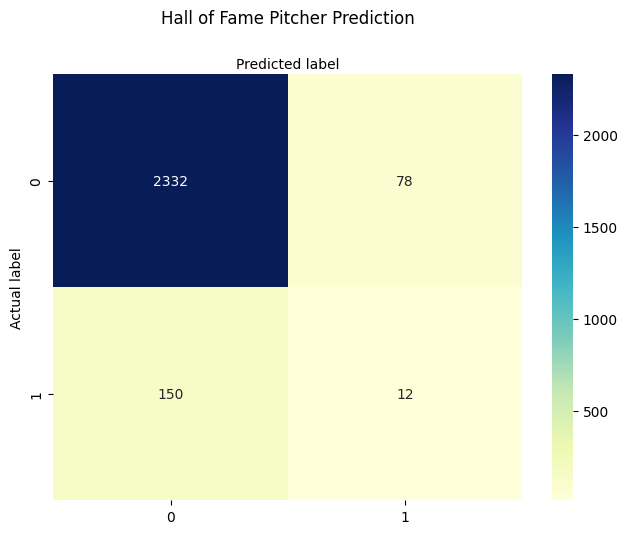

In [ ]:
plot_confusion_matrix(hof_test_pitching, svm_pred_1, class_names = [0, 1], title = "Hall of Fame Pitcher Prediction")

In [ ]:
svm_batting_model = svm.SVC(kernel='sigmoid', random_state=0)
svm_batting_model.fit(batting_train_hof, hof_train_batting)

SVC(kernel='sigmoid', random_state=0)

In [ ]:
svm_pred_2 = svm_batting_model.predict(batting_test_hof)
print("Accuracy: ", accuracy_score(svm_pred_2, hof_test_batting))
print("Classification Report:\n", classification_report(svm_pred_2, hof_test_batting))

Accuracy:  0.8981121970812692
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      7129
           1       0.04      0.05      0.04       340

    accuracy                           0.90      7469
   macro avg       0.49      0.49      0.49      7469
weighted avg       0.91      0.90      0.90      7469



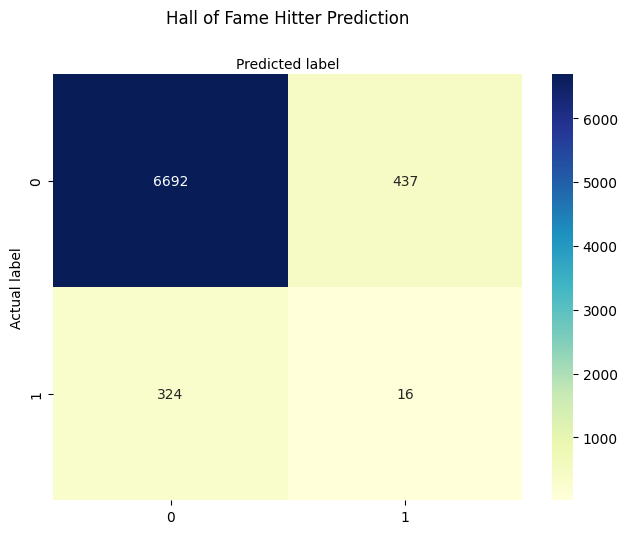

In [ ]:
plot_confusion_matrix(svm_pred_2, hof_test_batting, class_names = [0, 1], title = "Hall of Fame Hitter Prediction")

In [ ]:
batting_salary_data = TensorDataset(batting_train_salary, salary_train_batting)
dataloader = DataLoader(batting_salary_data, batch_size=1024, shuffle=True)

In [ ]:
n_epochs = 300;
optimizer = salary_batting_fc_optimizer
torch.cuda.empty_cache()
salary_batting_fully_connected.to(device)

for epoch in range(n_epochs):
  for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    outputs = salary_batting_fully_connected(x_batch)
    loss = salary_batting_loss(outputs.squeeze(1), y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print("Epoch: %d, Loss: %f" % (epoch, math.sqrt(float(loss))))

Epoch: 0, Loss: 4218118236.968151
Epoch: 1, Loss: 55978640.026010
Epoch: 2, Loss: 2647815.016910
Epoch: 3, Loss: 2764517.627062
Epoch: 4, Loss: 2743127.143739
Epoch: 5, Loss: 2753735.727974
Epoch: 6, Loss: 2544403.974567
Epoch: 7, Loss: 2732818.213710
Epoch: 8, Loss: 2344342.276716
Epoch: 9, Loss: 2565000.019549
Epoch: 10, Loss: 2671359.595208
Epoch: 11, Loss: 2668429.750432
Epoch: 12, Loss: 2559125.457020
Epoch: 13, Loss: 2596854.611970
Epoch: 14, Loss: 3425205.150752
Epoch: 15, Loss: 2523710.064564
Epoch: 16, Loss: 2381673.102701
Epoch: 17, Loss: 2837242.352426
Epoch: 18, Loss: 2801958.627783
Epoch: 19, Loss: 2981053.421670
Epoch: 20, Loss: 2615794.521007
Epoch: 21, Loss: 2878634.570542
Epoch: 22, Loss: 2762719.549105
Epoch: 23, Loss: 2747609.825133
Epoch: 24, Loss: 2760410.761874
Epoch: 25, Loss: 2557135.805733
Epoch: 26, Loss: 2607404.425738
Epoch: 27, Loss: 2871974.082557
Epoch: 28, Loss: 2581961.124144
Epoch: 29, Loss: 2529365.400987
Epoch: 30, Loss: 2492933.625790
Epoch: 31, Los

In [ ]:
pitching_salary_data = TensorDataset(pitching_train_salary, salary_train_pitching)
dataloader = DataLoader(pitching_salary_data, batch_size=1024, shuffle=True)

In [ ]:
n_epochs = 300;
optimizer = salary_pitching_fc_optimizer
torch.cuda.empty_cache()
salary_pitching_fully_connected.to(device)

for epoch in range(n_epochs):
  for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    outputs = salary_pitching_fully_connected(x_batch)
    loss = salary_pitching_loss(outputs.squeeze(1), y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print("Epoch: %d, Loss: %f" % (epoch, math.sqrt(float(loss))))

Epoch: 0, Loss: 845831006416.913574
Epoch: 1, Loss: 121614936267.113037
Epoch: 2, Loss: 17485813426.763359
Epoch: 3, Loss: 2514270976.051388
Epoch: 4, Loss: 361395834.223712
Epoch: 5, Loss: 52036540.928229
Epoch: 6, Loss: 7939503.552826
Epoch: 7, Loss: 2454947.475212
Epoch: 8, Loss: 2390373.539666
Epoch: 9, Loss: 2535187.633570
Epoch: 10, Loss: 2798133.447980
Epoch: 11, Loss: 2700021.793476
Epoch: 12, Loss: 2552059.262108
Epoch: 13, Loss: 2243869.659587
Epoch: 14, Loss: 2333864.376550
Epoch: 15, Loss: 2745853.947417
Epoch: 16, Loss: 2198600.613612
Epoch: 17, Loss: 2420212.681167
Epoch: 18, Loss: 2660769.765505
Epoch: 19, Loss: 2540490.034090
Epoch: 20, Loss: 2692023.649085
Epoch: 21, Loss: 2573752.245668
Epoch: 22, Loss: 2238965.872376
Epoch: 23, Loss: 2141551.746517
Epoch: 24, Loss: 2784717.119594
Epoch: 25, Loss: 2167930.857170
Epoch: 26, Loss: 2249338.198365
Epoch: 27, Loss: 2690805.173986
Epoch: 28, Loss: 2745956.765632
Epoch: 29, Loss: 2351502.238050
Epoch: 30, Loss: 2673541.63488

In [ ]:
pitching_hof_data = TensorDataset(pitching_train_hof, hof_train_pitching)
dataloader = DataLoader(pitching_hof_data, batch_size=1024, shuffle=True)

In [ ]:
n_epochs = 300;
optimizer = hof_pitching_fc_optimizer
torch.cuda.empty_cache()
hof_pitching_fully_connected.to(device)
running_loss = 0
correct = 0
total = 0

for epoch in range(n_epochs):
  for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    outputs = hof_pitching_fully_connected(x_batch)
    loss = torch.nn.CrossEntropyLoss()(outputs, y_batch.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Calculate accuracy
    _, predicted = torch.max(outputs, 1)
    total += y_batch.size(0)
    correct += (predicted == y_batch).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
  print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

c:\Users\Tysug\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/300], Loss: 0.5672, Accuracy: 94.90%
Epoch [2/300], Loss: 1.0971, Accuracy: 94.90%
Epoch [3/300], Loss: 1.5951, Accuracy: 94.90%
Epoch [4/300], Loss: 2.0647, Accuracy: 94.90%
Epoch [5/300], Loss: 2.5067, Accuracy: 94.90%
Epoch [6/300], Loss: 2.9263, Accuracy: 94.90%
Epoch [7/300], Loss: 3.3234, Accuracy: 94.90%
Epoch [8/300], Loss: 3.6995, Accuracy: 94.90%
Epoch [9/300], Loss: 4.0579, Accuracy: 94.90%
Epoch [10/300], Loss: 4.4022, Accuracy: 94.90%
Epoch [11/300], Loss: 4.7367, Accuracy: 94.90%
Epoch [12/300], Loss: 5.0545, Accuracy: 94.90%
Epoch [13/300], Loss: 5.3607, Accuracy: 94.90%
Epoch [14/300], Loss: 5.6539, Accuracy: 94.90%
Epoch [15/300], Loss: 5.9346, Accuracy: 94.90%
Epoch [16/300], Loss: 6.2096, Accuracy: 94.90%
Epoch [17/300], Loss: 6.4795, Accuracy: 94.90%
Epoch [18/300], Loss: 6.7426, Accuracy: 94.90%
Epoch [19/300], Loss: 7.0057, Accuracy: 94.90%
Epoch [20/300], Loss: 7.2613, Accuracy: 94.90%
Epoch [21/300], Loss: 7.5047, Accuracy: 94.90%
Epoch [22/300], Loss: 

In [ ]:
pitching_test_hof = torch.from_numpy(pitching_test_hof).float()
hof_test_pitching = torch.from_numpy(hof_test_pitching.to_numpy()).float()

Test Accuracy: 93.70%
Test Precision: 0.9685, Test Recall: 0.5000


c:\Users\Tysug\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


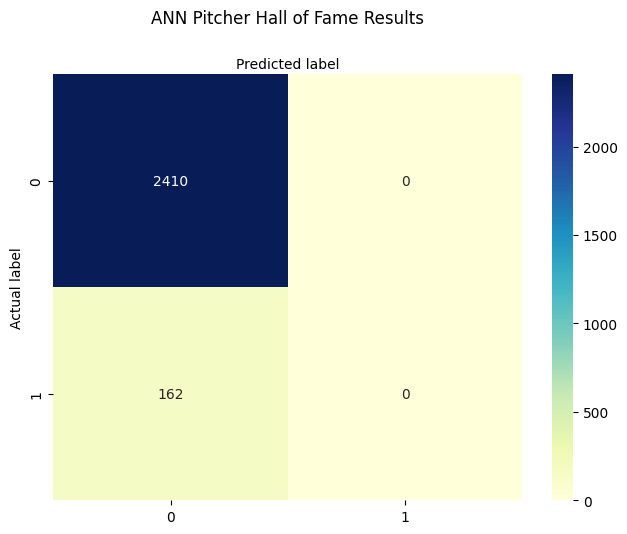

In [ ]:
# 8. Evaluate the model on the test set
hof_pitching_fully_connected.eval()  # Set the model to evaluation mode
pitching_hof_data_val = TensorDataset(pitching_test_hof, hof_test_pitching)
dataloader = DataLoader(pitching_hof_data_val, batch_size=1024, shuffle=True)
correct = 0
total = 0
all_true_labels = []
all_pred_labels = []

with torch.no_grad():  # No need to compute gradients during evaluation
    for X_batch, y_batch in dataloader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      outputs = hof_pitching_fully_connected(X_batch)
      _, predicted = torch.max(outputs, 1)
      total += y_batch.size(0)
      correct += (predicted == y_batch).sum().item()
      all_true_labels.extend(y_batch.cpu().numpy())
      all_pred_labels.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")
test_precision, test_recall = calculate_precision_recall(all_true_labels, all_pred_labels)

print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
plot_confusion_matrix(all_true_labels, all_pred_labels, class_names=[0,1], title = "ANN Pitcher Hall of Fame Results")

In [ ]:
batting_train_hof = torch.from_numpy(batting_train_hof).float()
hof_train_batting = torch.from_numpy(hof_train_batting.to_numpy()).float()

In [ ]:
batting_hof_data = TensorDataset(batting_train_hof, hof_train_batting)
dataloader = DataLoader(batting_hof_data, batch_size=1024, shuffle=True)

In [ ]:
n_epochs = 300;
optimizer = hof_batting_fc_optimizer
torch.cuda.empty_cache()
hof_batting_fully_connected.to(device)
total = 0
correct = 0
running_loss = 0

for epoch in range(n_epochs):
  for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    outputs = hof_batting_fully_connected(x_batch)
    loss = torch.nn.CrossEntropyLoss()(outputs, y_batch.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Calculate accuracy
    _, predicted = torch.max(outputs, 1)
    total += y_batch.size(0)
    correct += (predicted == y_batch).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
  print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

c:\Users\Tysug\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/300], Loss: 0.7680, Accuracy: 9.68%
Epoch [2/300], Loss: 1.3944, Accuracy: 51.53%
Epoch [3/300], Loss: 1.9273, Accuracy: 65.76%
Epoch [4/300], Loss: 2.3935, Accuracy: 72.88%
Epoch [5/300], Loss: 2.8101, Accuracy: 77.14%
Epoch [6/300], Loss: 3.1887, Accuracy: 79.99%
Epoch [7/300], Loss: 3.5388, Accuracy: 82.02%
Epoch [8/300], Loss: 3.8653, Accuracy: 83.55%
Epoch [9/300], Loss: 4.1749, Accuracy: 84.73%
Epoch [10/300], Loss: 4.4704, Accuracy: 85.68%
Epoch [11/300], Loss: 4.7539, Accuracy: 86.46%
Epoch [12/300], Loss: 5.0259, Accuracy: 87.10%
Epoch [13/300], Loss: 5.2895, Accuracy: 87.65%
Epoch [14/300], Loss: 5.5469, Accuracy: 88.12%
Epoch [15/300], Loss: 5.7983, Accuracy: 88.52%
Epoch [16/300], Loss: 6.0460, Accuracy: 88.88%
Epoch [17/300], Loss: 6.2894, Accuracy: 89.19%
Epoch [18/300], Loss: 6.5288, Accuracy: 89.47%
Epoch [19/300], Loss: 6.7678, Accuracy: 89.72%
Epoch [20/300], Loss: 7.0033, Accuracy: 89.95%
Epoch [21/300], Loss: 7.2367, Accuracy: 90.15%
Epoch [22/300], Loss: 7

In [ ]:
batting_test_hof = torch.from_numpy(batting_test_hof).float()
hof_test_batting = torch.from_numpy(hof_test_batting.to_numpy()).float()

Test Accuracy: 93.93%
Test Precision: 0.9697, Test Recall: 0.5000


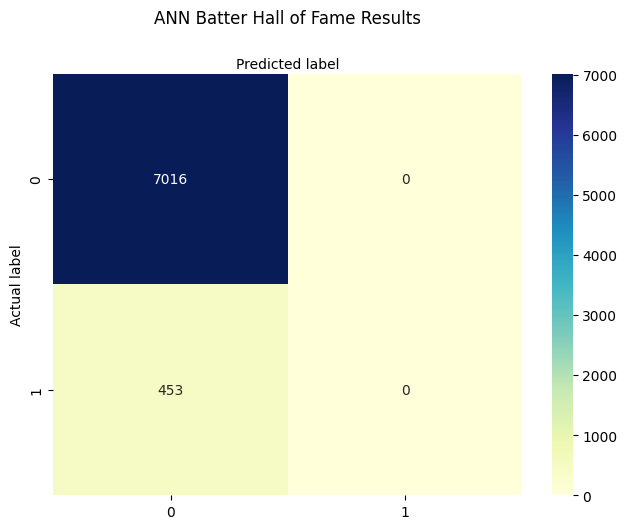

In [ ]:
# Evaluate the model on the test set
batting_hof_data_val = TensorDataset(batting_test_hof, hof_test_batting)
dataloader = DataLoader(batting_hof_data_val, batch_size=1024, shuffle=True)
hof_batting_fully_connected.eval()  # Set the model to evaluation mode
correct = 0
total = 0
incorrect = 0
all_true_labels = []
all_pred_labels = []

with torch.no_grad():  # No need to compute gradients during evaluation
    for X_batch, y_batch in dataloader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      outputs = hof_batting_fully_connected(X_batch)
      _, predicted = torch.max(outputs, 1)
      total += y_batch.size(0)
      correct += (predicted == y_batch).sum().item()
      incorrect += (predicted != y_batch).sum().item()
      all_true_labels.extend(y_batch.cpu().numpy())
      all_pred_labels.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")
test_precision, test_recall = calculate_precision_recall(all_true_labels, all_pred_labels)

print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
plot_confusion_matrix(all_true_labels, all_pred_labels, class_names=[0,1], title = "ANN Batter Hall of Fame Results")